## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10,20]

In [8]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping

results = {}
for patience in PATIENCE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    earlystop = EarlyStopping(monitor="val_accuracy", 
                              patience=patience, 
                              verbose=1
                              )
    print("Patient=%d" % patience)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    model_num = "Patient-%s" % str(patience)
    results[model_num] = {'train-loss': train_loss,'valid-loss': valid_loss,
                          'train-acc': train_acc,'valid-acc': valid_acc}

Patient=10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)        

50000/50000 [==============================] - 1s 30us/step - loss: 0.5447 - accuracy: 0.8421 - val_loss: 1.6360 - val_accuracy: 0.4952
Epoch 47/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.5268 - accuracy: 0.8476 - val_loss: 1.6692 - val_accuracy: 0.4899
Epoch 48/50
50000/50000 [==============================] - 1s 30us/step - loss: 0.5089 - accuracy: 0.8559 - val_loss: 1.6682 - val_accuracy: 0.4914
Epoch 00048: early stopping
Patient=20
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
__________________________________________________

50000/50000 [==============================] - 2s 30us/step - loss: 0.6102 - accuracy: 0.8156 - val_loss: 1.5986 - val_accuracy: 0.4922
Epoch 44/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.5906 - accuracy: 0.8241 - val_loss: 1.6214 - val_accuracy: 0.4935
Epoch 45/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.5750 - accuracy: 0.8287 - val_loss: 1.6129 - val_accuracy: 0.4902
Epoch 46/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.5588 - accuracy: 0.8353 - val_loss: 1.6219 - val_accuracy: 0.4933
Epoch 47/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.5389 - accuracy: 0.8431 - val_loss: 1.6336 - val_accuracy: 0.4946
Epoch 48/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.5225 - accuracy: 0.8504 - val_loss: 1.6674 - val_accuracy: 0.4842
Epoch 49/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.5074 - accuracy: 0.8557 - val_loss: 1.6700

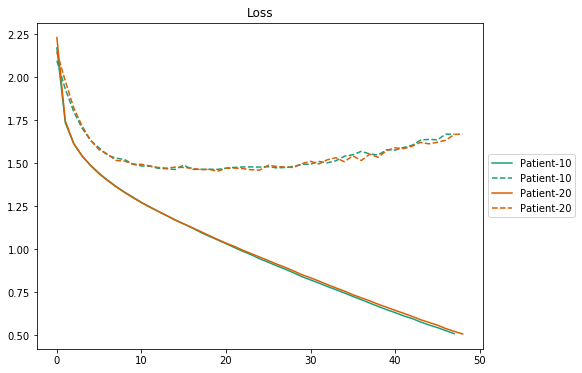

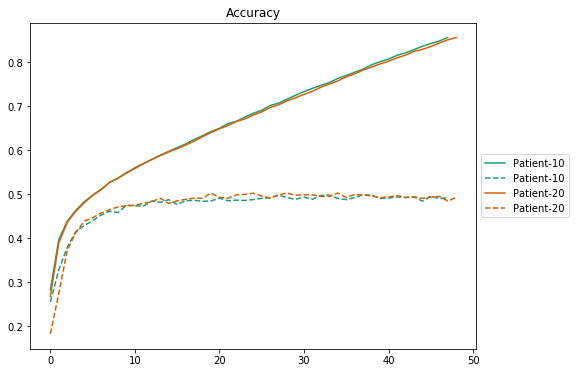

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('Dark2')
color_bar = [cm(0),cm(1)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()